# Homework 3

**The Barnstable Case**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
plt.style.use("seaborn")
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Part 3

- For the full sample of market returns, **1926-2021**, calculate the level excess returns not (log returns). 

In [7]:
filepath = "C:/Users/dcste/OneDrive/Portfolio_Theory/Homework_Jupyter/portfolio_theory/barnstable_analysis_data.xlsx"
descrip = pd.read_excel(filepath, sheet_name = "descriptions")
descrip = descrip.rename(columns={"Unnamed: 0":"Ticker"})
descrip.head()

,Ticker,Description
0,SPX,S&P500 Index
1,TB1M,Treasury Bill (1M) Index


In [42]:
returns = pd.read_excel(filepath, sheet_name="data").rename(columns = {"date": "Date"}).set_index("Date")
returns["Level"] = returns["SPX"] - returns["TB1M"]
returns.dropna(inplace = True)
returns.head()

,SPX,TB1M,Level
Date,,,
1926-01-30,-0.0018,0.0031,-0.0048
1926-02-27,-0.0333,0.0026,-0.0359
1926-03-31,-0.0577,0.0026,-0.0603
1926-04-30,0.0385,0.0023,0.0363
1926-05-28,0.0136,0.0027,0.0109


## Question 1

1. **Historical VaR**
Starting at $t=61$, calculate the historic based **VaR**, based on expanding the sample period from $1$ (Jan 1926) to $t-1$.

    1. Plot the historical **VaR** over time. 
    2. Calculate the frequency of periods where the actual level returns are less than the historical Value at Risk. 
    3. What drawbacks do you see from this VaR.

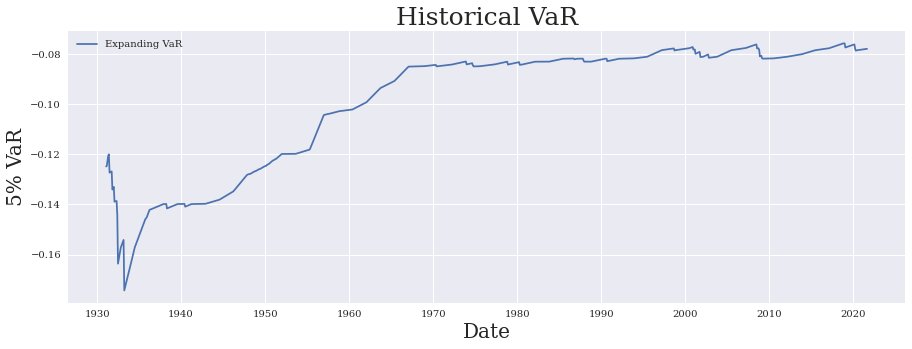

In [93]:
historical_var = pd.Series(returns["Level"].shift().expanding(min_periods = 60).quantile(.05), name = "Expanding Var")


plt.figure(figsize = (15,5))
plt.plot(historical_var, label = "Expanding VaR")
plt.xlabel("Date", size = 20)
plt.ylabel("5% VaR", size = 20)
plt.title("Historical VaR", size = 25)
plt.legend(loc = 0)

In [99]:
# Calculate the frequency the actual historical risk premium is less than the historical value at risk
frequency = len(returns[returns["Level"] < historical_var])/len(historical_var.dropna())
print("The frequency in which the actual return is lower than the 5% Value at Risk is {}%".format(round(frequency, 4)*100))

The frequency in which the actual return is lower than the 5% Value at Risk is 2.88%


Theoretically, we should see that about 5% of all returns are lower than the 5% **Value at Risk** measure, however, **empirically** we see that $2.88$% of the total level returns were less than the 5% value at risk measure. This means the return tails are skewwed. 

## Question 2 Volatility

- We will calculate a time-series of volatility estimates using a few different methods:

**Expanding Volatility**

$\sigma^2_t = \frac{1}{t-1}\sum_{i=1}^{t-1}r^2_i$

- If we begin at $t=61$, our first estimate is based on 60 data points.

**Rolling Volatitlity**
$\sigma^2_t = \frac{1}{m}\sum_{i=1}^mr^2_{t-i}$

- If we begin at $m = 60$ so our first calculation of the rolling volatility is at $t=61$ and has a full 60 data points

**Exponentially Weighted Moving Average**

$\sigma^2_t = \sum_{i=1}^{\N-1}\lambda^{(i-1)} r^2_{t-i}$

- Rather than estimating lambda, simply use $\lambda = .97$ and initialize $\sigma_{1} = .15$

**GARCH(1,1)**

*Generalized AutoRegressive Conditional Heteroskedastic Model*

$\sigma^2_t = \alpha_0 + \gamma_1\sigma^2_{t-1} + \alpha_1 r^2_{t-1}$

- To estimate *GARCH(1,1)* use the **ARCH** package in python


- Estimate all of these time-series volatility estimates using the different methods. 


In [115]:
stdv = np.sqrt(returns["Level"].shift(1).expanding(min_periods=60).mean().to_frame("Expanding Volatility"))
stdv["Rolling Volatility"] = np.sqrt(returns["Level"].rolling(60).mean())



,Expanding Volatility,Rolling Volatility
Date,,
2021-04-30,0.0829,0.1167
2021-05-28,0.0832,0.1158
2021-06-30,0.0832,0.1173
2021-07-30,0.0832,0.1165
2021-08-31,0.0833,0.1186


In [122]:
# Estimating EWMA

IGARCH = arch_model(returns["Level"])
theta = 0.97
IGARCH.volatility = EWMAVariance(theta)
IGARCH_model = IGARCH.fit()
IGARCH_model

Iteration:      1,   Func. Count:      3,   Neg. LLF: 4368087.277886891
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1842.4652930715574
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1842.4652930726525
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


                Constant Mean - EWMA/RiskMetrics Model Results                
Dep. Variable:                  Level   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:           EWMA/RiskMetrics   Log-Likelihood:                1842.47
Distribution:                  Normal   AIC:                          -3682.93
Method:            Maximum Likelihood   BIC:                          -3677.90
                                        No. Observations:                 1136
Date:                Sat, Oct 15 2022   Df Residuals:                     1135
Time:                        19:31:12   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.1901e-03  1.484e-03      4.845  1.264e-06 [4.

In [124]:
GARCH = arch_model(returns["Level"], vol = "Garch", p = 1, o = 0, q = 1, dist = "Normal")
GARCH_model = GARCH.fit()
GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.6852774436705056e+17
Iteration:      2,   Func. Count:     17,   Neg. LLF: 21671229965.535995
Iteration:      3,   Func. Count:     25,   Neg. LLF: 4679.329715295809
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3590.869563905556
Iteration:      5,   Func. Count:     41,   Neg. LLF: -1595.8655131107512
Iteration:      6,   Func. Count:     49,   Neg. LLF: -336.511436129314
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1598.391856628051
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1497.7401199848991
Iteration:      9,   Func. Count:     73,   Neg. LLF: -1842.1455291753648
Iteration:     10,   Func. Count:     80,   Neg. LLF: -1894.858638476966
Iteration:     11,   Func. Count:     87,   Neg. LLF: -1114.2247744705467
Iteration:     12,   Func. Count:     94,   Neg. LLF: -1896.5773724558703
Iteration:     13,   Func. Count:     99,   Neg. LLF: -1896.5773726300313
Optimization terminated successfully    (Exi

mu          8.1361e-03
omega       6.9126e-05
alpha[1]    1.3999e-01
beta[1]     8.3979e-01
Name: params, dtype: float64

In [141]:
stdv[["GARCH", "EWMA"]] = None
stdv.iloc[0,2:] = 0.15
for i in range(1,len(stdv)):
    stdv["EWMA"].iloc[i] = np.sqrt((stdv["EWMA"].iloc[i-1]**2 * theta) + (1-theta)*(returns["Level"].iloc[i-1]**2)) 
    stdv["GARCH"].iloc[i] = np.sqrt(GARCH_model.params["omega"] + (stdv["GARCH"].iloc[i-1]**2)*GARCH_model.params['beta[1]'] + GARCH_model.params["alpha[1]"]*(returns["Level"].iloc[i-1]**2))
stdv.dropna(inplace = True)

Text(0.5, 1.0, '$\\sigma_{t}$ Extrapolation')

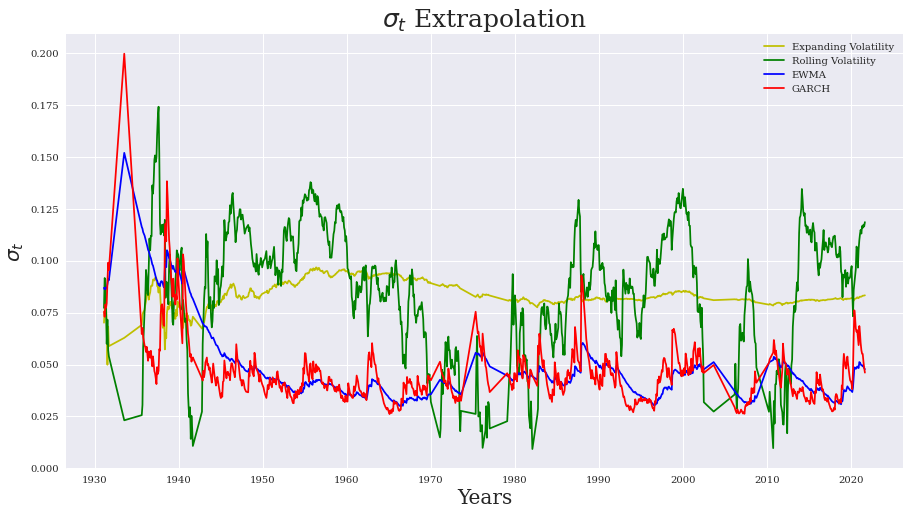

In [153]:
plt.figure(figsize = (15,8))
plt.plot(stdv["Expanding Volatility"], label = "Expanding Volatility", c= "y")
plt.plot(stdv["Rolling Volatility"], label = 'Rolling Volatility', c = "g")
plt.plot(stdv["EWMA"], label = "EWMA", c = "b")
plt.plot(stdv["GARCH"], label = "GARCH", c = "r")
plt.legend(loc = 0)
plt.xlabel("Years", size = 20)
plt.ylabel(r"$\sigma_{t}$", size = 20)
plt.title(r'$\sigma_{t}$ Extrapolation', size = 25)

For each method, calculate the 5th percentile, 1-month ahead VaR. We use a slighly simpler *VaR* calculation by dropping $\mu$ from that formula, and rounding the normal distribution $z$-score to $-1.65$

In [191]:
def vol_calcuation(df, VaR = -1.65):
    forecasted_val = pd.DataFrame(data = None, index = df.columns, columns = ["VaR Risk Forecast"])
    last_obs = len(df)
    for col in df.columns:
        forecasted_val.loc[col,"VaR Risk Forecast"] = df[col].iloc[last_obs-1]*VaR
        forecasted_val.loc[col, "Month"] = df.index[last_obs-1]

    return round(forecasted_val, 4)

In [192]:
vol_calcuation(stdv, VaR = -1.65)

,VaR Risk Forecast,Month
Expanding Volatility,-0.1375,2021-08-31
Rolling Volatility,-0.1956,2021-08-31
GARCH,-0.0761,2021-08-31
EWMA,-0.0788,2021-08-31


In [194]:
# In order to calculate the VaR in all Periods just multiply the DataFrame by -1.65
VaR = -1.65*stdv
VaR.tail()


,Expanding Volatility,Rolling Volatility,GARCH,EWMA
Date,,,,
2021-04-30,-0.1368,-0.1925,-0.0911,-0.0816
2021-05-28,-0.1372,-0.1911,-0.0909,-0.0819
2021-06-30,-0.1372,-0.1936,-0.0845,-0.0806
2021-07-30,-0.1373,-0.1922,-0.08,-0.0797
2021-08-31,-0.1375,-0.1956,-0.0761,-0.0788


Text(0.5, 0, 'Date')

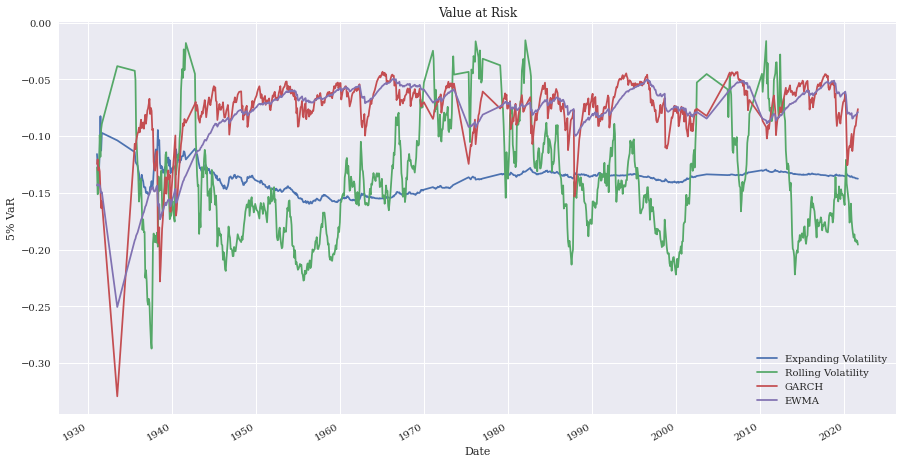

In [197]:
VaR.plot(figsize = (15,8))
plt.title("Value at Risk")
plt.ylabel("5% VaR")
plt.xlabel("Date")

For each of these three vol-based VaR estimates, calculate the frequency of periods in which the actual VaR is less than the historical **VaR**.

In [198]:
freq = pd.DataFrame(data = None, index = ["Frequency"], columns = VaR.columns)
for col in freq:
    freq[col] = len(VaR[returns.loc[VaR.index,"Level"] < VaR[col]])/len(VaR[col].dropna().index)
round(freq, 4)

,Expanding Volatility,Rolling Volatility,GARCH,EWMA
Frequency,0.0068,0.0169,0.0407,0.035


Obviously, here the *GARCH* model outperforms all the other volitility estimates. 